## Importing the Dependencies

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, MaxPooling2D, Dense, Flatten, Input
import tensorflow as tf

## Data Collection

In [3]:
POSITIVE_PATH = os.path.join('faceData', 'pos_img')
NEGATIVE_PATH = os.path.join('faceData', 'neg_img')
ANCHOR_PATH = os.path.join('faceData', 'anc_img')

In [ ]:
os.makedirs(POSITIVE_PATH)
os.makedirs(NEGATIVE_PATH)
os.makedirs(ANCHOR_PATH)

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [27]:
import uuid

In [52]:
cap = cv2.VideoCapture('selfievideo.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue
    
    frame = cv2.resize(frame, (640,480))
    
    frame = frame[90:90+250, 250:+250+250, :]
    
    # collecting anchor images
    if cv2.waitKey(10) & 0xFF == ord('a'):
        imgname = os.path.join(ANCHOR_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
        
    # collectiong positive images
    if cv2.waitKey(10) & 0xFF == ord('p'):
        imgname = os.path.join(POSITIVE_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)


    cv2.imshow("Facial Recognition", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

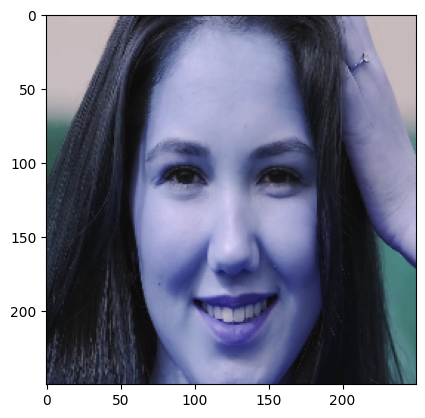

In [55]:
plt.imshow(frame)
plt.show()

In [53]:
frame.shape

(250, 250, 3)

## Data Preprocessing

In [4]:
anchor = tf.data.Dataset.list_files(ANCHOR_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POSITIVE_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEGATIVE_PATH+'\*.jpg').take(300)

In [12]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path) 
    img = tf.io.decode_jpeg(byte_img)  
    img = tf.image.resize(img, (100,100))  # resizing
    img = img/255.0  # scaling
    return img
    

In [6]:
test = anchor.as_numpy_iterator()
test.next()

b'faceData\\anc_img\\e577fb1e-aabc-11ed-8edf-70cd0df93246.jpg'

In [7]:
img = preprocess('faceData\\anc_img\\e02488e4-aabc-11ed-8fec-70cd0df93246.jpg')
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        ...,
        [0.22083333, 0.19240196, 0.18063726],
        [0.25906864, 0.23946078, 0.22769608],
        [0.12230392, 0.10661764, 0.09485294]],

       [[0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        ...,
        [0.20980392, 0.18137255, 0.16960785],
        [0.17524509, 0.15637255, 0.14460784],
        [0.1877451 , 0.17205882, 0.16029412]],

       [[0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        [0.74509805, 0.7372549 , 0.7882353 ],
        ...,
        [0.24828431, 0.21985294, 0.21029411],
        [0.19166666, 0.175     , 0.16323529],
        [0.17205882, 0.15637255, 0.14460784]],

       ...,

       [[0.40808824, 0.44338235, 0.22769608],
        [0.39

In [8]:
img.numpy().min(), img.numpy().max()

(0.007352941, 0.99240196)

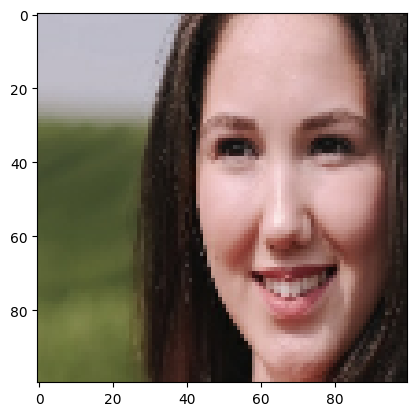

In [9]:
plt.imshow(img);

In [10]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
test = data.as_numpy_iterator()
input = test.next()
input

(b'faceData\\anc_img\\df5bcfee-aabc-11ed-8b19-70cd0df93246.jpg',
 b'faceData\\pos_img\\5b7a5222-aabd-11ed-97a1-70cd0df93246.jpg',
 1.0)

In [12]:
# building twin function
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [13]:
# testing twin function
result = preprocess_twin(*input)
result[2]

1.0

In [14]:
# dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [15]:
sample = data.as_numpy_iterator() # testing
samp = sample.next()

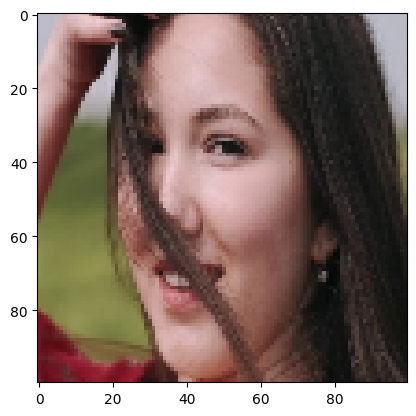

In [16]:
plt.imshow(samp[1])

In [18]:
samp[2]

1.0

In [19]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [20]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Model

In [21]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    c3 = Conv2D(12, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [22]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 12)        24588     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 12)          0 

In [3]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
        
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
            

In [4]:
l1 = L1Dist()

In [49]:
def siamese_model():
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # distance layer
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='siamese_model')

In [50]:
siamese_model = siamese_model()

In [51]:
siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38247628    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[4][0]      

## Training

In [52]:
loss_func = tf.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-4)

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=optimizer, siamese_model = siamese_model)

In [57]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = loss_func(y, yhat)
    print(loss)
    
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [58]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
            
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        

In [59]:
train(train_data, 50)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 1384s 51s/step

 Epoch 2/50
27/27 [==============================] - 1127s 41s/step

 Epoch 3/50
27/27 [==============================] - 1053s 39s/step

 Epoch 4/50
27/27 [==============================] - 895s 33s/step

 Epoch 5/50
27/27 [==============================] - 1007s 37s/step

 Epoch 6/50
27/27 [==============================] - 1066s 39s/step

 Epoch 7/50
27/27 [==============================] - 1182s 44s/step

 Epoch 8/50
27/27 [==============================] - 1335s 49s/step

 Epoch 9/50
27/27 [==============================] - 1381s 51s/step

 Epoch 10/50
27/27 [==============================] - 1386s 51s/step

 Epoch 11/50
27/27 [==============================] - 1402s 52s/step

 Epoch 12/50
27/27 [==============================] - 1398s 52s/step

 Epoch 13/50
27

KeyboardInterrupt: 

## Evalutation

In [60]:
from tensorflow.keras.metrics import Recall, Precision

test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_hat = siamese_model.predict([test_input, test_val])

In [61]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0]

In [62]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [64]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


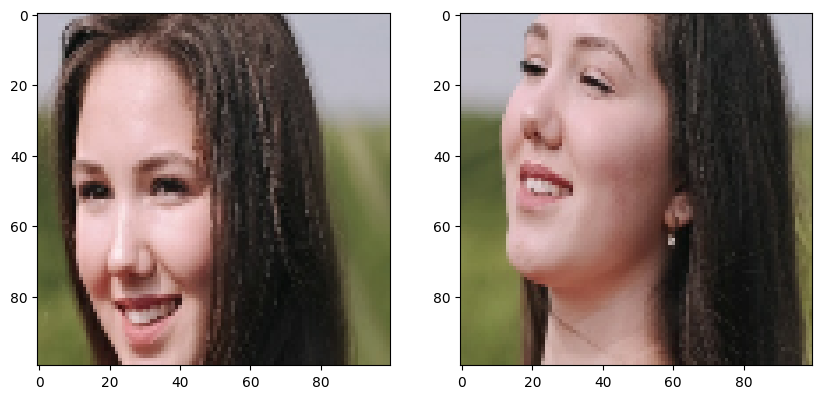

In [65]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [69]:
# Save weights
siamese_model.save('siamesemodelfinal.h5')

In [17]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelfinal.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [18]:
# View model summary
siamese_model.summary()

Model: "siamese_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38247628    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]      

## Real Time Verification

In [15]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [21]:
cap = cv2.VideoCapture('selfievideo.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue
    
    frame = cv2.resize(frame, (640,480))
    
    frame = frame[90:90+250, 250:+250+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        
        print(verified)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

True


In [11]:
cap.release()
cv2.destroyAllWindows()

In [22]:
results

[array([[0.5451057]], dtype=float32),
 array([[0.98433554]], dtype=float32),
 array([[0.9996086]], dtype=float32),
 array([[0.9997921]], dtype=float32),
 array([[0.99996686]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999964]], dtype=float32),
 array([[0.9999678]], dtype=float32),
 array([[0.93481505]], dtype=float32),
 array([[0.6500563]], dtype=float32),
 array([[0.9997321]], dtype=float32),
 array([[0.99956214]], dtype=float32),
 array([[0.9983052]], dtype=float32),
 array([[0.992844]], dtype=float32),
 array([[0.45607907]], dtype=float32),
 array([[0.9989082]], dtype=float32),
 array([[0.9918488]], dtype=float32),
 array([[0.99999964]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999186]], dtype=float32),
 array([[0.93481505]], dtype=float32),
 array([[0.99992895]], dtype=float32),
 array([[0.9820082]], dtype=float32),
 array([[0.99906576]], dtype=float32),
 array([[0.99308366]], dtype=float32),
 array([[0.99999535]], dtype=float32),
 array([[0.9999